In [1]:
import matplotlib.pyplot as plt
import torch
from matplotlib.patches import Wedge
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from pinn.geometry import compute_area
from pinn.network import SofaNet

plt.rcParams['text.usetex'] = True

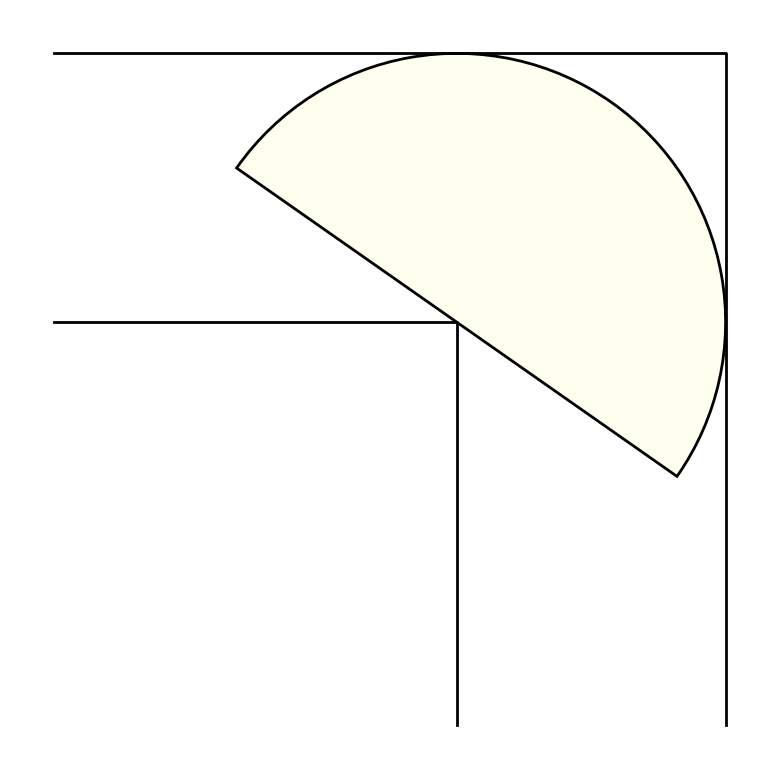

In [2]:
plt.figure(dpi=200)
ax = plt.gca()
ax.plot([-1.5, 0, 0], [0, 0, -1.5], c="k", lw=1)
ax.plot([-1.5, 1, 1], [1, 1, -1.5], c="k", lw=1)
ax.add_patch(Wedge((0, 0), 1, -35, 180 - 35, facecolor="ivory", edgecolor="k", lw=1))
ax.set_aspect(1.)
ax.axis("off")
plt.savefig("figs/circ.png", bbox_inches="tight", pad_inches=0.01)
plt.show()

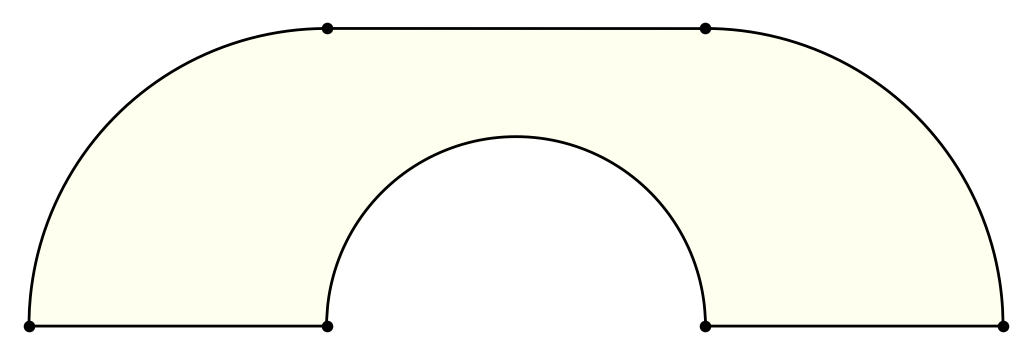

In [3]:
plt.figure(dpi=200)
ax = plt.gca()
t = torch.linspace(0, 1, 100)
alpha = torch.linspace(0, torch.pi / 2, 100)
a = b = 2 / torch.pi
xp = a * (torch.cos(2 * alpha) - 1)
yp = b * torch.sin(2 * alpha)
dt_alpha = torch.ones_like(alpha) * torch.pi / 2
dt_xp = -a * 2 * torch.sin(2 * alpha) * dt_alpha
dt_yp = b * 2 * torch.cos(2 * alpha) * dt_alpha
gg = compute_area(t, alpha, xp, yp, dt_alpha, dt_xp, dt_yp, return_geometry=True)
plt.plot(gg["x_sample"], gg["y_sample_lower"], lw=1, c='k')
plt.plot(gg["x_sample"], gg["y_sample_upper"], lw=1, c='k')
plt.scatter([0, 1, 0, -2 * a, -2 * a - 1, -2 * a],
            [0, 0, 1, 0, 0, 1], c='k', s=10, zorder=1000)
plt.fill_between(gg["x_sample"], y1=gg["y_sample_upper"], y2=gg["y_sample_lower"],
                 color='ivory')
ax.set_xlim(gg["x_sample"][0] - .03, gg["x_sample"][-1] + .03)
ax.set_ylim(-.03, 1 + .03)
ax.set_aspect(1.)
ax.axis("off")
plt.savefig("figs/Hammersley.png", bbox_inches="tight", pad_inches=0.01)
plt.show()

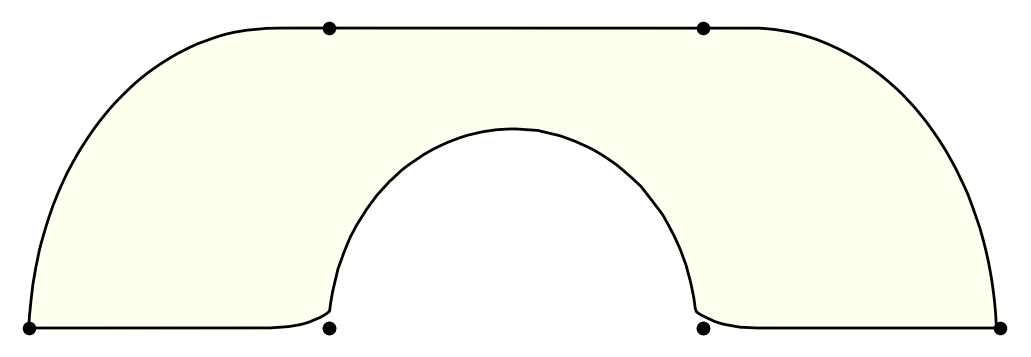

In [4]:
plt.figure(dpi=200)
ax = plt.gca()
gg = torch.load("outputs/pinn/recent/best_geometry.pt")
for key in gg.keys():
    gg[key] = gg[key].detach()
mid2 = gg["x_sample"][0] + gg["x_sample"][-1]
plt.plot(gg["x_sample"], gg["y_sample_lower"], lw=1, c='k')
plt.plot(gg["x_sample"], gg["y_sample_upper"], lw=1, c='k')
xe = torch.stack([gg["x_ehi"], gg["y_ehi"]], dim=1)
xp = torch.stack([gg["xp"], gg["yp"]], dim=1)
dist = torch.min(torch.norm(xe[:, None] - xp[None, :], dim=-1), dim=1)[0]
intersect = dist.argmin()
plt.scatter([gg["x_sample"][0], gg["x_ehi"][0], gg["x_ehi"][intersect], gg["x_eho"][0]],
            [gg["y_sample_lower"][0], gg["y_ehi"][0], gg["y_ehi"][intersect], gg["y_eho"][0]], c='k', s=15, zorder=1000)
plt.scatter(
    [mid2 - gg["x_sample"][0] - .01, mid2 - gg["x_ehi"][0], mid2 - gg["x_ehi"][intersect], mid2 - gg["x_eho"][0]],
    [gg["y_sample_lower"][0], gg["y_ehi"][0], gg["y_ehi"][intersect], gg["y_eho"][0]], c='k', s=15, zorder=1000)
plt.fill_between(gg["x_sample"], y1=gg["y_sample_upper"], y2=gg["y_sample_lower"],
                 color='ivory')
ax.set_xlim(gg["x_sample"][0] - .03, gg["x_sample"][-1] + .03)
ax.set_ylim(-.03, 1 + .03)
ax.set_aspect(1.)
ax.axis("off")
plt.savefig("figs/Gerver.png", bbox_inches="tight", pad_inches=0.01)
plt.show()

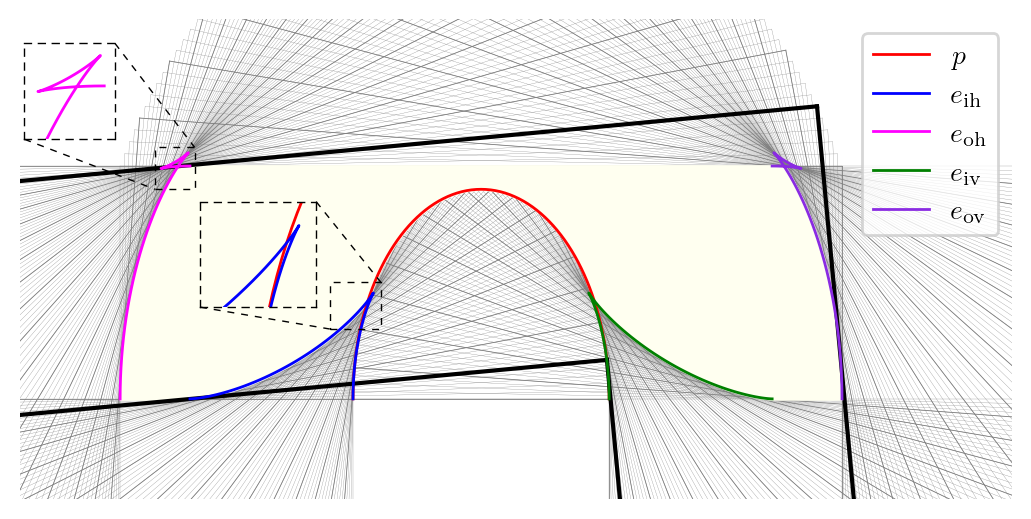

In [5]:
plt.figure(dpi=200)
ax = plt.gca()
t = torch.linspace(0, 1, 85)
alpha = torch.linspace(0, torch.pi / 2, 85)
a = .55
b = .9
xp = a * (torch.cos(2 * alpha) - 1)
yp = b * torch.sin(2 * alpha)
dt_alpha = torch.ones_like(alpha) * torch.pi / 2
dt_xp = -a * 2 * torch.sin(2 * alpha) * dt_alpha
dt_yp = b * 2 * torch.cos(2 * alpha) * dt_alpha
gg = compute_area(t, alpha, xp, yp, dt_alpha, dt_xp, dt_yp, return_geometry=True)

for i in range(0, len(t), 1):
    plt.plot(gg["x_lhi"][i], gg["y_lhi"][i], lw=.1, c='gray', zorder=-100)
    plt.plot(gg["x_lvi"][i], gg["y_lvi"][i], lw=.1, c='gray', zorder=-100)
    plt.plot(gg["x_lho"][i], gg["y_lho"][i], lw=.1, c='gray', zorder=-100)
    plt.plot(gg["x_lvo"][i], gg["y_lvo"][i], lw=.1, c='gray', zorder=-100)

for i in range(0, len(t), 5):
    plt.plot(gg["x_lhi"][i], gg["y_lhi"][i], lw=.3, c='gray', zorder=-200)
    plt.plot(gg["x_lvi"][i], gg["y_lvi"][i], lw=.3, c='gray', zorder=-200)
    plt.plot(gg["x_lho"][i], gg["y_lho"][i], lw=.3, c='gray', zorder=-200)
    plt.plot(gg["x_lvo"][i], gg["y_lvo"][i], lw=.3, c='gray', zorder=-200)

i = 5
plt.plot(gg["x_lhi"][i], gg["y_lhi"][i], lw=1.5, c='k', zorder=100)
plt.plot(gg["x_lvi"][i], gg["y_lvi"][i], lw=1.5, c='k', zorder=100)
plt.plot(gg["x_lho"][i], gg["y_lho"][i], lw=1.5, c='k', zorder=100)
plt.plot(gg["x_lvo"][i], gg["y_lvo"][i], lw=1.5, c='k', zorder=100)

plt.plot(gg["xp"], gg["yp"], lw=1., c='r', label="$p$")
plt.plot(gg["x_ehi"], gg["y_ehi"], lw=1., c='b', zorder=200, label="$e_\mathrm{ih}$")
plt.plot(gg["x_eho"], gg["y_eho"], lw=1., c='magenta', zorder=200, label="$e_\mathrm{oh}$")
plt.plot(gg["x_evi"], gg["y_evi"], lw=1., c='green', zorder=200, label="$e_\mathrm{iv}$")
plt.plot(gg["x_evo"], gg["y_evo"], lw=1., c='blueviolet', zorder=200, label="$e_\mathrm{ov}$")
plt.legend(loc="upper right")

ax_up = ax.inset_axes(
    [-0.05, 0.75, 0.2, 0.2],
    xlim=(-1.95, -1.78), ylim=(.9, 1.08), xticks=[], yticks=[])
ax_up.plot(gg["x_eho"], gg["y_eho"], lw=1, c='magenta')
ax_up.set_aspect(1.)
ax_up.set_xticks([])
ax_up.set_yticks([])
plt.setp(ax_up.spines.values(), lw=0.5, ls=(0, (5, 5)))
mark_inset(ax, ax_up, loc1=1, loc2=3, fc="none", ec="k", ls=(0, (5, 5)), lw=0.5, zorder=1000)

ax_lo = ax.inset_axes(
    [0.13, 0.40, 0.22, 0.22],
    xlim=(-1.1 - .1, -1.0 + .02), ylim=(.3, .5), xticks=[], yticks=[])
ax_lo.plot(gg["xp"], gg["yp"], lw=1, c='r', label="$p$")
ax_lo.plot(gg["x_ehi"], gg["y_ehi"], lw=1, c='b')
ax_lo.set_aspect(1.)
ax_lo.set_xticks([])
ax_lo.set_yticks([])
ax_lo.set_facecolor('ivory')
plt.setp(ax_lo.spines.values(), lw=0.5, ls=(0, (5, 5)))
mark_inset(ax, ax_lo, loc1=1, loc2=3, fc="none", ec="k", ls=(0, (5, 5)), lw=0.5, zorder=1000)

plt.fill_between(gg["x_sample"], y1=gg["y_sample_upper"], y2=gg["y_sample_lower"],
                 color='ivory')

ax.set_xlim(gg["x_sample"][0] - .03 - .4, gg["x_sample"][-1] + .03 + .7)
ax.set_ylim(-.03 - .4, 1 + .03 + .6)
ax.set_aspect(1.)
ax.axis("off")
plt.savefig("figs/geometry.png", bbox_inches="tight", pad_inches=0.01)
plt.show()

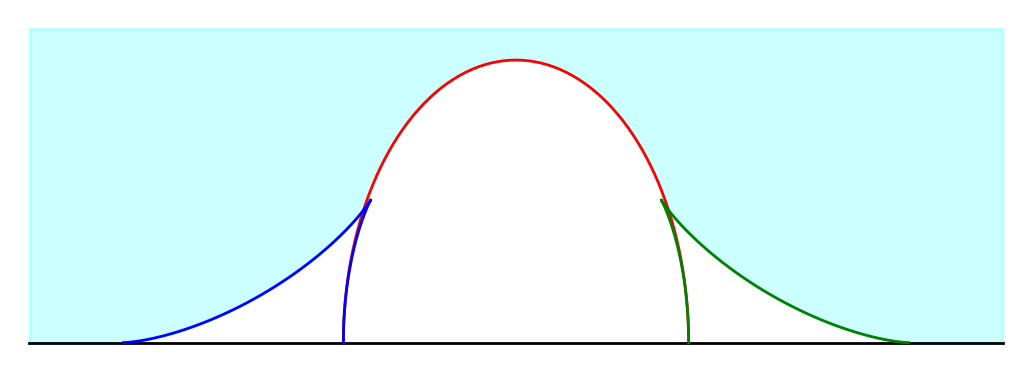

In [6]:
plt.figure(dpi=200)
ax = plt.gca()

plt.plot(gg["xp"], gg["yp"], lw=1., c='r', label="$p$")
plt.plot(gg["x_ehi"], gg["y_ehi"], lw=1., c='b', zorder=200)
plt.plot(gg["x_evi"], gg["y_evi"], lw=1., c='green', zorder=200)
plt.plot([gg["x_sample"][0], gg["x_sample"][-1]], [0, 0], lw=1, c='k')

plt.fill_between(gg["x_sample"], y1=torch.ones_like(gg["x_sample"]), y2=gg["y_sample_lower"],
                 color='aqua', alpha=.2)

ax.set_xlim(gg["x_sample"][0] - .03, gg["x_sample"][-1] + .03)
ax.set_ylim(-.03, 1 + .03)
ax.set_aspect(1.)
ax.axis("off")
plt.savefig("figs/water_lower.png", bbox_inches="tight", pad_inches=0.01)
plt.show()

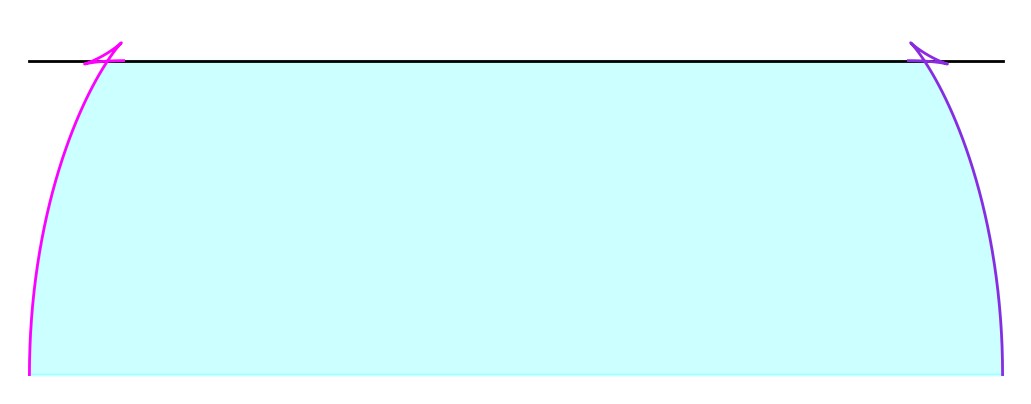

In [7]:
plt.figure(dpi=200)
ax = plt.gca()

plt.plot([gg["x_sample"][0], gg["x_sample"][-1]], [1, 1], lw=1, c='k')
plt.plot(gg["x_eho"], gg["y_eho"], lw=1., c='magenta', zorder=200)
plt.plot(gg["x_evo"], gg["y_evo"], lw=1., c='blueviolet', zorder=200)
plt.fill_between(gg["x_sample"], y1=torch.zeros_like(gg["y_sample_upper"]), y2=gg["y_sample_upper"],
                 color='aqua', alpha=.2)

ax.set_xlim(gg["x_sample"][0] - .03, gg["x_sample"][-1] + .03)
ax.set_ylim(-.03, 1 + .03 + .1)
ax.set_aspect(1.)
ax.axis("off")
plt.savefig("figs/water_upper.png", bbox_inches="tight", pad_inches=0.01)
plt.show()

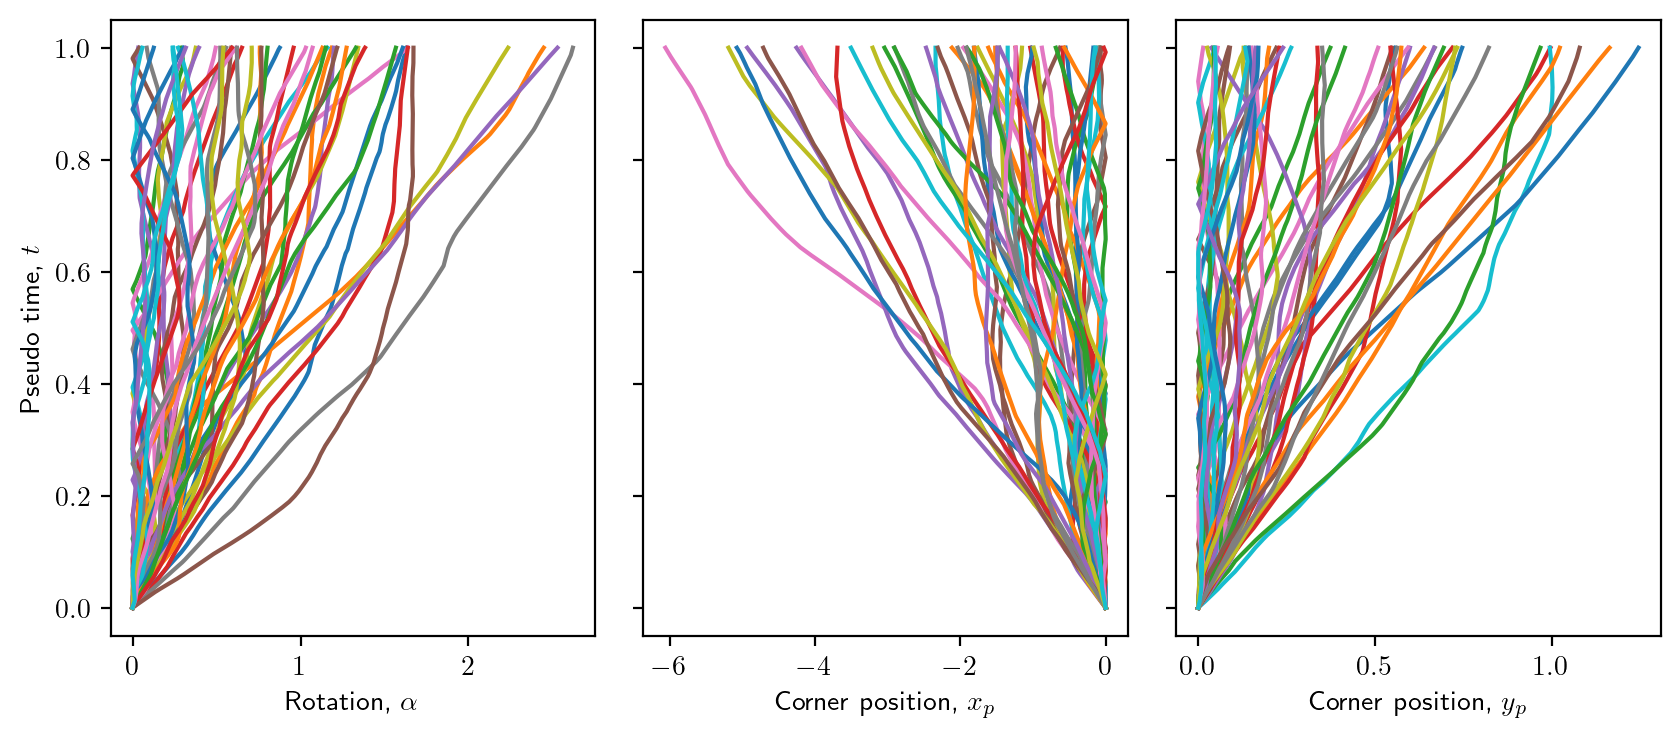

In [8]:
t = torch.linspace(0, 1, 1000)
f, ax = plt.subplots(1, 3, dpi=200, figsize=(10, 4), sharey=True)
plt.subplots_adjust(wspace=0.1)
for seed in range(0, 200, 4):
    torch.manual_seed(seed)
    model = SofaNet([128, 128, 128], alpha_scaling=2.5, xp_scaling=3., yp_scaling=2.)
    alpha, xp, yp, dt_alpha, dt_xp, dt_yp = model(t)
    ax[0].plot(alpha.detach(), t)
    ax[1].plot(xp.detach(), t)
    ax[2].plot(yp.detach(), t)
    ax[0].set_ylabel("Pseudo time, $t$")
    ax[0].set_xlabel("Rotation, $\\alpha$")
    ax[1].set_xlabel("Corner position, $x_p$")
    ax[2].set_xlabel("Corner position, $y_p$")
plt.savefig("figs/init.png", bbox_inches="tight", pad_inches=0.02)
plt.show()

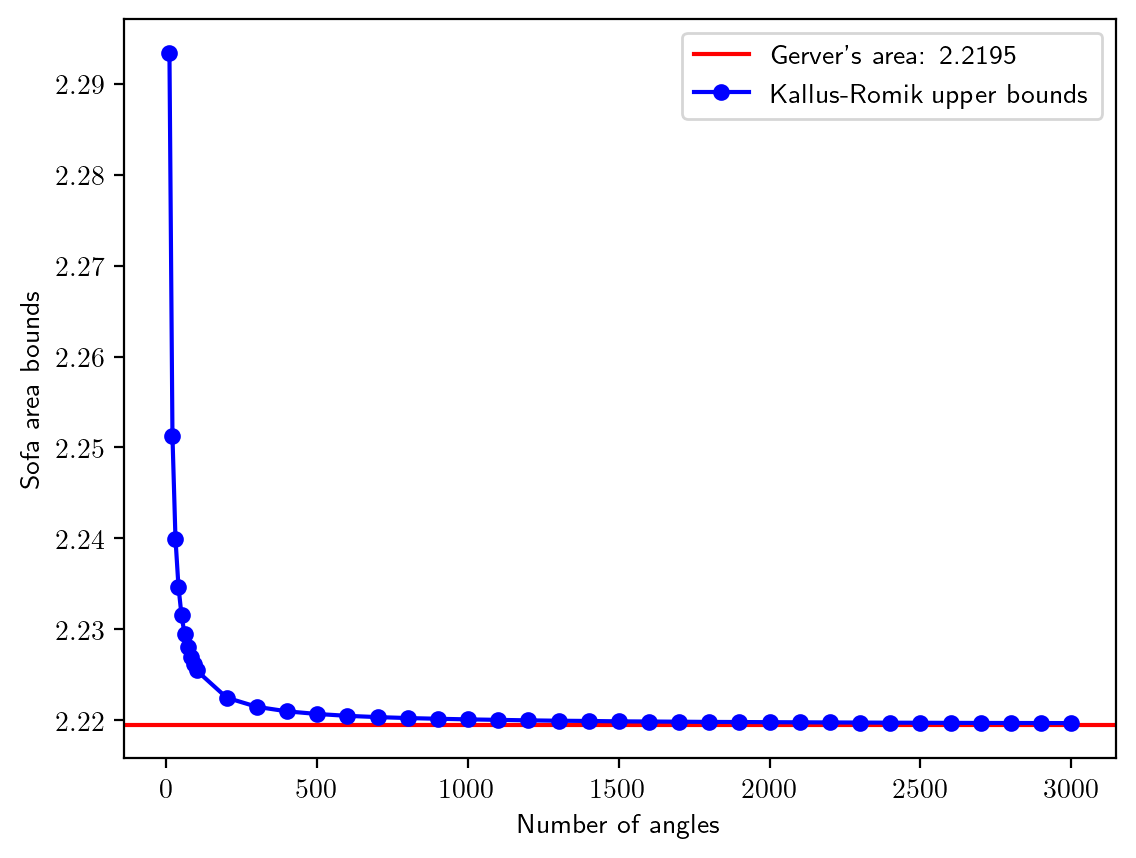

In [9]:
plt.figure(dpi=200)
ax = plt.gca()

ns = torch.cat((torch.arange(10, 100, 10), torch.arange(100, 3001, 100)))
areas = []
for n in ns:
    out_dir = f"outputs/upper/eq15_{n}"
    gg = torch.load(f"{out_dir}/best_geometry.pt")
    for key in gg.keys():
        gg[key] = gg[key].detach()
    areas.append(gg["area"])
plt.axhline(2.2195, c="r", label="Gerver's area: 2.2195")
plt.plot(ns, areas, c="b", label="Kallus-Romik upper bounds", marker="o", markersize=5)
plt.legend()
plt.xlabel("Number of angles")
plt.ylabel("Sofa area bounds")
plt.savefig("figs/upper_bound.png", bbox_inches="tight", pad_inches=0.01)
plt.show()